## This is based on MakeMyPostISRCCDfromRawForSpectractorSD 

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch


from astropy.io import fits




In [2]:
# Assembly task
# https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/isrTask.py

from lsst.ip.isr.assembleCcdTask import (AssembleCcdConfig, AssembleCcdTask)
from lsst.ip.isr.isrTask import (IsrTask, IsrTaskConfig)

#https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/overscan.py
from lsst.ip.isr import  OverscanCorrectionTaskConfig, OverscanCorrectionTask

In [3]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Butler 

In [5]:
import lsst.daf.butler as dafButler

In [6]:
embargo = True

In [7]:
if embargo:
    repo="/sdf/group/rubin/repo/oga/"
else:
    repo = "/sdf/group/rubin/repo/main"
butler = dafButler.Butler(repo)
registry = butler.registry

Select collection containing raw data 

In [8]:
collection='LATISS/raw/all'

## Select exposure type 

In [9]:
observation_type = 'engtest'

## Dataframe with the science exposures 

Set up dataframe to store the list of exposures and their information. Select only SCIENCE exposures 

In [10]:
df_science = pd.DataFrame(columns=['id', 'obs_id','day_obs', 'seq_num','time_start',
                                    'time_end' ,'type', 'target','filter_disp','zenith_angle',
                                    'expos','ra','dec','skyangle','science_program'])

In [11]:

#where_exps = "instrument='LATISS' AND exposure.observation_type='science' AND exposure.day_obs={0} AND physical_filter='{1}'".format(exp_date,physical_filter)
where_exps = "instrument='LATISS' AND exposure.observation_type='{0}'".format(observation_type)
#where_exps = "instrument='LATISS'"
for i, info in enumerate(registry.queryDimensionRecords('exposure',where=where_exps)):
    
    #if info.observation_type=='science':
    id_ = info.id
    obs_id_ = info.obs_id
    day_obs_ = info.day_obs
    seq_num_ = info.seq_num
    timespan_ = info.timespan
    timespan_begin_ = pd.to_datetime(timespan_.begin.to_string())
    timespan_end_ = pd.to_datetime(timespan_.end.to_string())
    timespan_begin_jd_ = timespan_.begin.jd
    timespan_begin_mjd_ = timespan_.begin.mjd

    observation_type_ = info.observation_type
    target_name_ = info.target_name
    physical_filter_ = info.physical_filter
    zenith_angle_ = info.zenith_angle
    exposure_time_ = info.exposure_time
    tracking_ra_ = info.tracking_ra
    tracking_dec_ = info.tracking_dec
    sky_angle_ = info.sky_angle
    science_program_ = info.science_program

    df_science.loc[i] = [id_, obs_id_, day_obs_, seq_num_,timespan_begin_,timespan_end_ ,observation_type_, \
                         target_name_, physical_filter_, zenith_angle_, exposure_time_,tracking_ra_, \
                         tracking_dec_, sky_angle_, science_program_]

    if i < 2:
        print(i)
        print(info)
        print("\t timespan:            ",info.timespan)
        print("\t timespan.begin:      ",info.timespan.begin)
        print("\t id:                  ",info.id)
        print("\t day_obs:             ",info.day_obs)
        print("\t seq_num:             ",info.seq_num)
        print("\t type-of-observation: ",info.observation_type)
        print("\t target:              ",info.target_name)
        print("-----------------------------------------------------")
    

0
exposure:
  instrument: 'LATISS'
  id: 2022090100007
  physical_filter: 'unknown~unknown'
  obs_id: 'AT_O_20220901_000007'
  exposure_time: 300.0
  dark_time: 300.235
  observation_type: 'engtest'
  observation_reason: 'engtest'
  day_obs: 20220901
  seq_num: 7
  seq_start: 7
  seq_end: 7
  group_name: '2022090100007'
  group_id: 2022090100007
  target_name: 'UNKNOWN'
  science_program: 'unknown'
  tracking_ra: None
  tracking_dec: None
  sky_angle: None
  azimuth: None
  zenith_angle: None
  has_simulated: False
  timespan: Timespan(begin=astropy.time.Time('2022-09-01 21:58:16.889985', scale='tai', format='iso'), end=astropy.time.Time('2022-09-01 22:03:17.125000', scale='tai', format='iso'))
	 timespan:             [2022-09-01T21:58:16.889985, 2022-09-01T22:03:17.125000)
	 timespan.begin:       2022-09-01 21:58:16.889985
	 id:                   2022090100007
	 day_obs:              20220901
	 seq_num:              7
	 type-of-observation:  engtest
	 target:               UNKNOWN
---

In [12]:
df_science.tail(5)

,id,obs_id,day_obs,seq_num,time_start,time_end,type,target,filter_disp,zenith_angle,expos,ra,dec,skyangle,science_program
2231,2023101100283,AT_O_20231011_000283,20231011,283,2023-10-12 00:08:39.428001,2023-10-12 00:08:44.664,engtest,HD 201424,SDSSr_65mm~empty,10.992545,5.0,317.870953,-39.886643,240.544426,cwfs-focus-sweep
2232,2023101100284,AT_O_20231011_000284,20231011,284,2023-10-12 00:08:52.829981,2023-10-12 00:08:58.063,engtest,HD 201424,SDSSr_65mm~empty,10.970651,5.0,317.870917,-39.886684,240.544650,cwfs-focus-sweep
2233,2023101100285,AT_O_20231011_000285,20231011,285,2023-10-12 00:09:06.339986,2023-10-12 00:09:11.571,engtest,HD 201424,SDSSr_65mm~empty,10.947164,5.0,317.870935,-39.886631,240.544321,cwfs-focus-sweep
2234,2023101100286,AT_O_20231011_000286,20231011,286,2023-10-12 00:09:19.848985,2023-10-12 00:09:25.078,engtest,HD 201424,SDSSr_65mm~empty,10.925541,5.0,317.870927,-39.886645,240.544428,cwfs-focus-sweep
2235,2023101100287,AT_O_20231011_000287,20231011,287,2023-10-12 00:09:33.209001,2023-10-12 00:09:38.445,engtest,HD 201424,SDSSr_65mm~empty,10.902378,5.0,317.870851,-39.886658,240.544629,cwfs-focus-sweep


In [13]:
len(df_science)

2236

## Select date, physical filter (filter~grating) and source 

### Available dates 

In [14]:
np.unique(np.array(df_science.day_obs.array))

array([20220901, 20220902, 20220906, 20220908, 20220912, 20220913,
       20220914, 20220922, 20220926, 20220927, 20220928, 20220929,
       20221004, 20221005, 20221007, 20221011, 20221012, 20221013,
       20221018, 20221020, 20221021, 20221025, 20221026, 20221027,
       20221104, 20221108, 20221109, 20221110, 20221115, 20221117,
       20221120, 20221121, 20221122, 20221123, 20221124, 20221128,
       20221129, 20221205, 20221206, 20221207, 20221208, 20221209,
       20221210, 20221211, 20221212, 20221213, 20230110, 20230111,
       20230112, 20230116, 20230117, 20230118, 20230119, 20230126,
       20230127, 20230128, 20230131, 20230201, 20230202, 20230209,
       20230213, 20230214, 20230215, 20230216, 20230227, 20230228,
       20230301, 20230302, 20230310, 20230314, 20230315, 20230316,
       20230321, 20230509, 20230510, 20230511, 20230523, 20230524,
       20230525, 20230629, 20230704, 20230705, 20230706, 20230717,
       20230718, 20230720, 20230721, 20230725, 20230801, 20230

In [15]:
# set 'all' to select all values 
exp_date = '20230921'

### Available sources 

In [16]:
if exp_date=='all':
    print(np.unique(np.array(df_science.target.array).astype('str')))
else:
    print(np.unique(np.array(df_science[df_science.day_obs==int(exp_date)].target.array).astype('str')))

['FlatField position' 'HD 197785' 'HD209952' 'HD214952' 'HD216956'
 'Park position' 'UNKNOWN' 'azel_target' 'slew_icrs']


In [17]:
# set 'all' to select all values 
source = 'all'

### Available filters 

In [18]:
#df_science[df_science.target==source]
#df_science[(df_science.target==source) & (df_science.day_obs==exp_date)]

In [19]:
if exp_date=='all' and source=='all':
    print(np.unique(np.array(df_science.filter_disp.array)))
elif exp_date!='all' and source=='all':
    print(np.unique(np.array(df_science[df_science.day_obs==int(exp_date)].filter_disp.array).astype('str')))
elif exp_date=='all' and source!='all':
    print(np.unique(np.array(df_science[df_science.target==source].filter_disp.array).astype('str')))
else:
    print(np.unique(np.array(df_science[(df_science.day_obs==int(exp_date))&(df_science.target==source)].filter_disp.array).astype('str')))

['SDSSg_65mm~empty' 'SDSSg_65mm~holo4_003' 'SDSSg_65mm~pinhole_1_1000'
 'SDSSr_65mm~empty' 'SDSSr_65mm~holo4_003' 'SDSSr_65mm~pinhole_1_1000'
 'empty~empty' 'empty~holo4_003' 'empty~pinhole_1_1000']


In [20]:
# set 'all' to select all values 
physical_filter = 'all'

In [21]:
print('Selectied date = ', exp_date)
print('Selected source = ', source)
print('Selected physical filter = ', physical_filter)

Selectied date =  20230921
Selected source =  all
Selected physical filter =  all


In [22]:
df_selected = df_science
if exp_date!='all':
    df_selected = df_selected[df_selected.day_obs==int(exp_date)]
if source!='all':
    df_selected = df_selected[df_selected.target==source]
if physical_filter!='all':
    df_selected = df_selected[df_selected.filter_disp==physical_filter]

In [23]:
df_selected.tail(5)

,id,obs_id,day_obs,seq_num,time_start,time_end,type,target,filter_disp,zenith_angle,expos,ra,dec,skyangle,science_program
2108,2023092100510,AT_O_20230921_000510,20230921,510,2023-09-22 04:06:58.422018,2023-09-22 04:07:28.667,engtest,HD214952,SDSSr_65mm~empty,18.501378,30.0,339.386820,-46.416532,115.207445,unknown
2109,2023092100515,AT_O_20230921_000515,20230921,515,2023-09-22 04:19:40.502012,2023-09-22 04:19:40.828,engtest,HD216956,SDSSr_65mm~empty,8.741399,0.1,344.405441,-29.626097,6.728151,unknown
2110,2023092100516,AT_O_20230921_000516,20230921,516,2023-09-22 04:21:34.779003,2023-09-22 04:22:05.012,engtest,HD216956,SDSSr_65mm~empty,9.156166,30.0,344.405348,-29.626078,6.728299,unknown
2111,2023092100524,AT_O_20230921_000524,20230921,524,2023-09-22 04:26:14.541999,2023-09-22 04:26:44.780,engtest,HD216956,empty~empty,10.162539,30.0,344.405358,-29.626095,6.728180,unknown
2112,2023092100525,AT_O_20230921_000525,20230921,525,2023-09-22 04:34:04.864011,2023-09-22 04:34:35.098,engtest,HD216956,empty~empty,11.861978,30.0,344.405434,-29.626099,6.728147,unknown


In [24]:
len(df_selected)

303

In [25]:
if exp_date!='all':
    assert df_selected.day_obs.unique()[0]==int(exp_date)

In [26]:
if source!='all':
    assert df_selected.target.unique()[0]==source

In [27]:
if physical_filter!='all':
    assert df_selected.filter_disp.unique()[0]==physical_filter

In [28]:
exposures_available = []
for index,row in df_selected.iterrows():
    #exposure_selected_ = row["day_obs"]*100000+row["seq_num"]
    exposure_available_ = row["id"]
    #print(exposure_selected_)
    exposures_available.append(exposure_available_)
print(exposures_available)

[2023092100001, 2023092100002, 2023092100003, 2023092100016, 2023092100019, 2023092100022, 2023092100037, 2023092100014, 2023092100017, 2023092100020, 2023092100023, 2023092100038, 2023092100015, 2023092100018, 2023092100021, 2023092100024, 2023092100036, 2023092100178, 2023092100181, 2023092100184, 2023092100179, 2023092100182, 2023092100185, 2023092100177, 2023092100180, 2023092100183, 2023092100186, 2023092100187, 2023092100190, 2023092100196, 2023092100199, 2023092100202, 2023092100205, 2023092100208, 2023092100211, 2023092100214, 2023092100217, 2023092100220, 2023092100223, 2023092100226, 2023092100229, 2023092100232, 2023092100235, 2023092100238, 2023092100241, 2023092100244, 2023092100247, 2023092100250, 2023092100253, 2023092100256, 2023092100259, 2023092100262, 2023092100265, 2023092100268, 2023092100271, 2023092100188, 2023092100191, 2023092100197, 2023092100200, 2023092100203, 2023092100206, 2023092100209, 2023092100212, 2023092100215, 2023092100218, 2023092100221, 202309210

In [30]:
exposures_selected = [2023092100524,2023092100525]

# Retrieve exposures from Butler and make pseudo-postISRCCD 

In [31]:
outdir_base = "./output_pseudo_postisrccd_img"
if not os.path.exists(outdir_base):
    os.makedirs(outdir_base)
    

if exp_date=='all':
    date_label = 'all_dates_'
else:
    date_label = str(exp_date)+'_'
if source=='all':
    source_label = 'all_sources_'
else:
    source_label = source+'_'
if physical_filter=='all':
    phys_filter_label = 'all_phys_filters'
else:
    phys_filter_label = physical_filter.replace('~','-')

outdir_ = date_label+source_label+phys_filter_label

outdir = os.path.join(outdir_base,outdir_)
if not os.path.exists(outdir):
    os.makedirs(outdir)

## Prepare ISR task and define its inputs with Butler 

In [32]:
# configuration
isr_config =  IsrTaskConfig()

In [33]:
isr_config.doDark = False
isr_config.doFlat =  False
isr_config.doFringe = False
isr_config.doDefect = True
isr_config.doLinearize = False
isr_config.doCrosstalk =  False
isr_config.doSaturationInterpolation = False
isr_config.overscan.fitType: 'MEDIAN_PER_ROW'
isr_config.doBias: True


In [34]:
isr_task = IsrTask(config=isr_config)

Prepare information and collections for calibration 

In [35]:
cameraName = 'LATISS'
'''
calibCollections = ['LATISS/defaults','LATISS/raw/all']
for col in registry.queryCollections("*LATISS/calib*"):
    #print(col)
    calibCollections.append(col)
'''
calibCollections = ['LATISS/calib','LATISS/raw/all']

In [36]:
butler = dafButler.Butler(repo, collections=calibCollections)
camera = butler.get('camera', instrument=cameraName)
#bias = butler.get('bias',instrument=cameraName,detector=0)
#defects = butler.get('defects',instrument=cameraName,detector=0)


In [37]:
show_plot = True

Astropy scale transformations

In [38]:
transform = AsinhStretch() + PercentileInterval(99.)
#transform = PercentileInterval(98.)

## Check that the ISR works with one exposure 

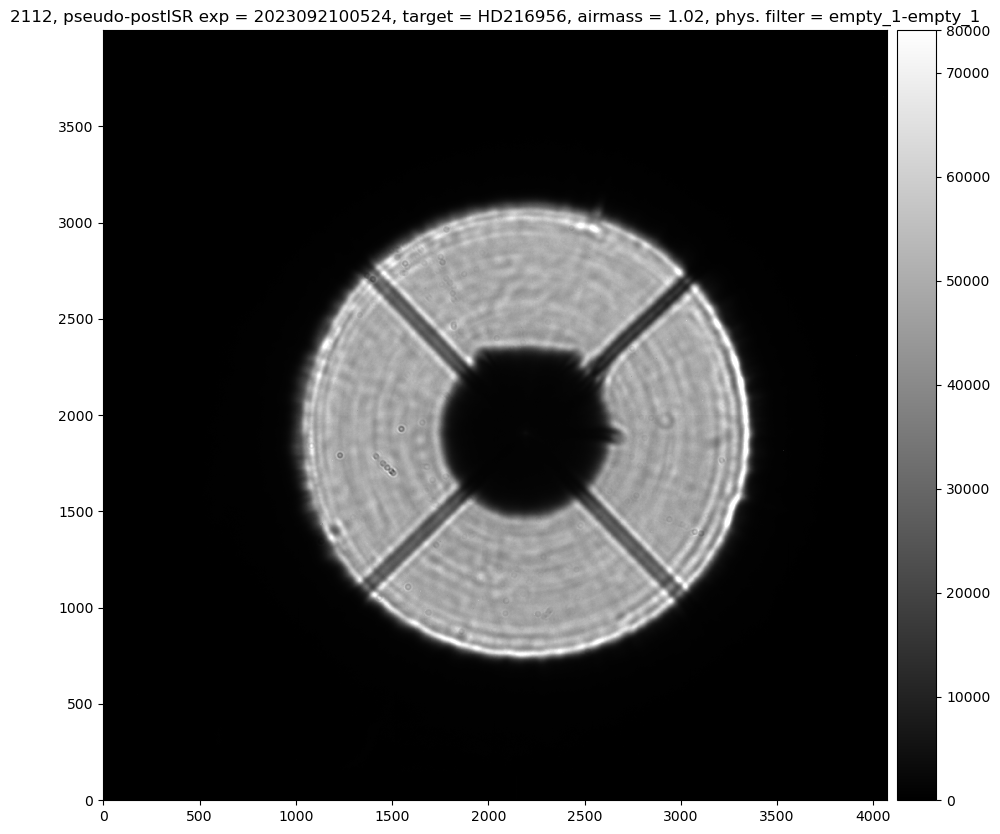

In [39]:
exp_selected_ = exposures_selected[0]

raw_img= butler.get('raw', dataId={'exposure': exp_selected_, 'instrument': 'LATISS', 'detector': 0}, collections = collection)
bias = butler.get("bias",instrument=cameraName, exposure= exp_selected_, detector=0, collections=calibCollections)
defects = butler.get('defects',instrument=cameraName, exposure= exp_selected_,detector=0,collections=calibCollections)

meta = raw_img.getMetadata()
md = meta.toDict()

object_ = md['OBJECT']
am_ = md['AMSTART']
filter_ = md['FILTER']
grating_ = md['GRATING']

#fast ISR 
isr_img = isr_task.run(raw_img,bias=bias,defects=defects)

if show_plot:
    %matplotlib inline
    
    rotated_array = isr_img.exposure.image.array[::-1,::-1] #rotate the array 180 degrees
    #np.flip(np.flip(a, 1), 0)


    fig = plt.figure(figsize=(12,10))
    afw_display = afwDisplay.Display(frame=fig)
    afw_display.scale('linear', 'zscale',None)
    the_title = f"{index}, pseudo-postISR exp = {exp_selected_}, target = {object_}, airmass = {am_:.2f}, phys. filter = {filter_}-{grating_}"
    afw_display.mtv(isr_img.exposure.image,title=the_title)

# Save in files

Set maximum number of fits files to be saved 

In [40]:
max_files = 2

In [41]:
for exp_selected_ in exposures_selected[:max_files]:
    
    #exposure_selected =row["date"]*100000+row["seq"]
    
    print(f"exposure selected = {exp_selected_}")


    raw_img= butler.get('raw', dataId={'exposure': exp_selected_, 'instrument': 'LATISS', 'detector': 0}, collections = collection)
    bias = butler.get("bias",instrument=cameraName, exposure= exp_selected_, detector=0, collections=calibCollections)
    defects = butler.get('defects',instrument=cameraName, exposure= exp_selected_,detector=0,collections=calibCollections)
    
    
    isr_img = isr_task.run(raw_img,bias=bias,defects=defects)
    
    arr=isr_img.exposure.image.array
    # 180 degree rotation
    rotated_array = arr[::-1,::-1] #rotate the array 180 degrees
    
    
    meta = raw_img.getMetadata()
    md = meta.toDict()

    #object_ = md['OBJECT']
    #am_ = md['AMSTART']
    #filter_ = md['FILTER']

    filename_out = f"exposure_{exp_selected_}_{physical_filter.replace('~','-')}_pseudo-postisrccd.fits"
    fullfilename_out=os.path.join(outdir,filename_out)
    
    print(f">>>>  output filename {filename_out}")
    
    hdr = fits.Header()
    
    for key,value in md.items():
        hdr[str(key)]=value
        
    if hdr['OBJECT']=='MU-COL':
        hdr['OBJECT'] = 'HD38666'
    # need this    
    hdr["AMEND"] = hdr["AMSTART"]
    try: 
        airmass_ = hdr["AIRMASS"]
    except:
        airmass_ = (hdr["AMEND"] + hdr["AMSTART"])/2.
        hdr["AIRMASS"] = airmass_
    
    # be aware weather data may be missing
    if hdr["AIRTEMP"] == None:
        hdr["AIRTEMP"] = 10.0

    if hdr["PRESSURE"] == None:
        hdr["PRESSURE"] = 744.

    if hdr["HUMIDITY"] == None:
        hdr["HUMIDITY"] = 50.

    if hdr["WINDSPD"] == None:
        hdr["WINDSPD"] = 5.

    if hdr["WINDDIR"] == None:
        hdr["WINDDIR"] = 0.   

    if hdr["SEEING"] == None:
        hdr["SEEING"] = 1.15
    
        
   
    
    # Be carefull for Spectractor, 2 hdu units are necessary
    
    primary_hdu = fits.PrimaryHDU(header=hdr)
    image_hdu = fits.ImageHDU(rotated_array)
    #image_hdu = fits.ImageHDU(arr)
    
    hdu_list = fits.HDUList([primary_hdu, image_hdu])
    
    hdu_list.writeto(fullfilename_out,overwrite=True)
    
    
    
    #if exposure_selected not in exposures_sel:
    #    break
    
    #if index>=0:
    #    break
    


exposure selected = 2023092100524


>>>>  output filename exposure_2023092100524_all_pseudo-postisrccd.fits
exposure selected = 2023092100525


>>>>  output filename exposure_2023092100525_all_pseudo-postisrccd.fits


## Check that the images were correctly saved 

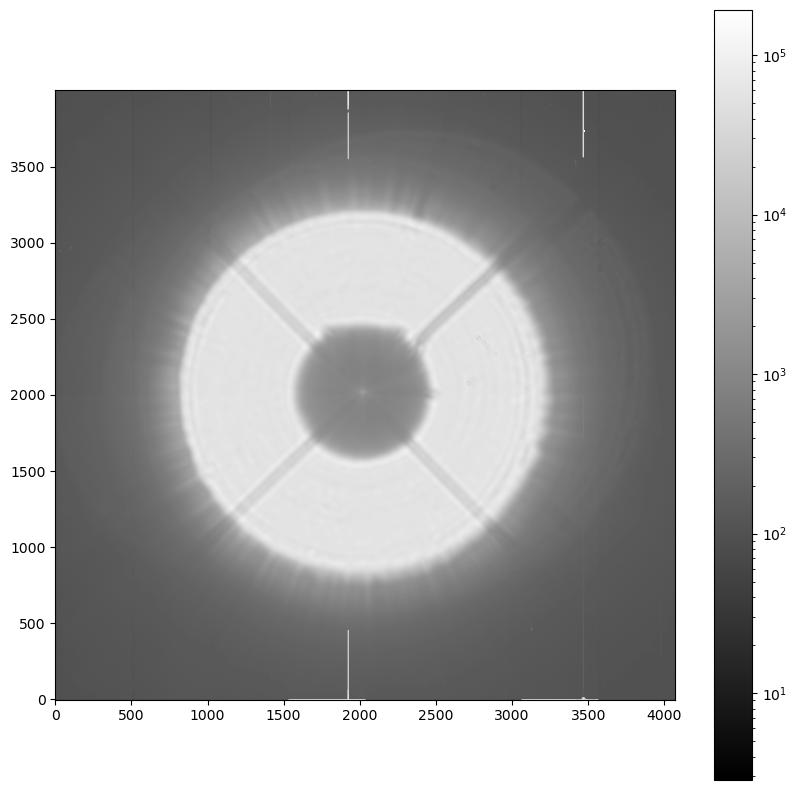

In [42]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
im = ax.imshow(rotated_array,cmap="gray",origin='lower',norm=LogNorm())
plt.colorbar(im,ax=ax)